# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

17 campmpaigns between May 2008 and November 2010 with 79354 contacts.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import category_encoders as ce
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

from sklearn import set_config
set_config(display="diagram")

In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


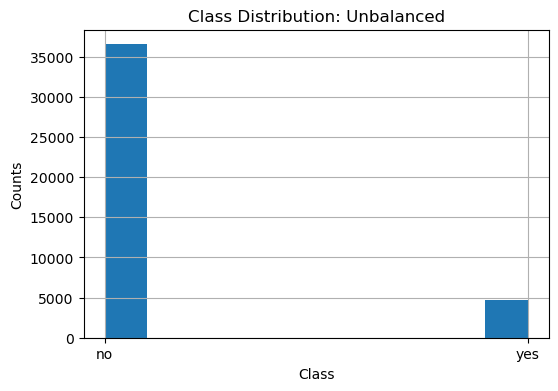

<Figure size 640x480 with 0 Axes>

In [4]:
# Class graph shows unbalanced dataset
plt.figure(figsize=(6, 4))
df.y.hist()
plt.title('Class Distribution: Unbalanced')
plt.ylabel('Counts')
plt.xlabel('Class')
plt.show()
plt.savefig('17-1-Class')

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Results Understanding the Features
1. There are not null values on the dataset
2. Column duration should be removed as suggested above to have a realistic predictive model
3. These categorical columns need transformation:
['job',
'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']   
4. Remove duplicates

In [5]:
df.shape

(41188, 21)

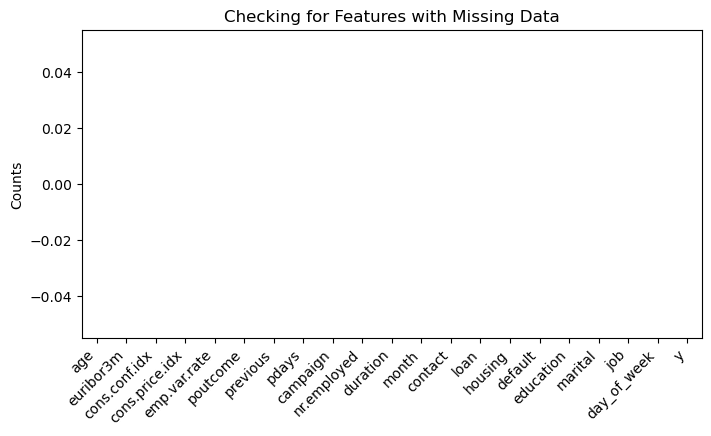

In [6]:
#Checing for missing data
plt.figure(figsize=(8, 4))
df.isnull().sum().sort_values().plot(kind = 'bar')
plt.title('Checking for Features with Missing Data')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.show()

In [7]:
# Get a list of categorical_features
categorical_features = df.drop('y', axis = 1).select_dtypes('object').columns.tolist()
selector = make_column_selector(dtype_include=object)
selector

In [8]:
# Checking for duplicates
df_dups = df[df.duplicated()]
df_dups.shape

(12, 21)

In [9]:
#Remove duplicates
df = df.drop_duplicates(keep='last')

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

### Business Objective

The business objective is to increase the efficiency of phone campaigns for long-term deposit subscriptions by reducing the number of contacts, while identifying the key characteristics that influence success. This will enable better management of available resources—such as human effort, phone calls, and time—by focusing on a high-quality, cost-effective campaings set of potential buying customers.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null  floa

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

### Encoding Options

Started with JamesSteinEncoder because of how it manages features with many unique values (i.e month), however, it gives lower performance for classification problems. 

Switch to TargetEncoder has similar features but it is better for binary classification. Noticed that the performance and metrics are better with TargetEncoder.

The transformer below encodes and scaled the data.

In [11]:
# Using JamesSteinEncoder
#transformer = make_column_transformer((ce.JamesSteinEncoder(model='binary'), categorical_features),
#                                      remainder = StandardScaler())
transformer = make_column_transformer((TargetEncoder(), categorical_features),
                                       remainder = StandardScaler())

In [12]:
y_numerical  = df['y'].map({'yes': 1, 'no': 0})
X_numerical = transformer.fit_transform(df.drop('y', axis = 1), y_numerical)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set. Given the large volume of data, decided to have a test size of 40%

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y_numerical, test_size = 0.4, random_state = 42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

### Using DummyClassifier to stablish the baseline.

In [95]:
# Establishing the base line using DummyClassifier
dummy_clf = ''
baseline_score = ''

dummy_clf = DummyClassifier().fit(X_train, y_train)
baseline_score = dummy_clf.score(X_test, y_test)

#y_preds = dummy_clf.predict(X_test)
#class_report = classification_report(y_test, y_preds)

print(f' Baseline score: {baseline_score: .4f}')
#print(class_report)

 Baseline score:  0.8853


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [17]:
# Calling LogisticRegression with default parameters
logreg = LogisticRegression(max_iter = 1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### Problem 9: Score the Model

What is the accuracy of your model?

In [18]:
y_preds = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_preds)
print(f'Accuracy Basic Logistic Regression: {accuracy: .2f}')

Accuracy Basic Logistic Regression:  0.91


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [19]:
# Creating a dataframe to track results
results_df = pd.DataFrame(columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy'])

***KNearestNeighborsClassifier***

In [20]:
# KNearestNeighborsClassifier. Using the GridSearchCV to get the best fit time

knn = KNeighborsClassifier()

# Leaving the default for the params.
params = {
    'n_neighbors': [5]   # Number of neighbors to consider     
}

# Fitting the model
grid_knn = GridSearchCV(estimator = knn, param_grid = params, scoring='accuracy', cv=5)
grid_knn.fit(X_train, y_train)

# Getting predictions
preds_train = grid_knn.predict(X_train)
preds_test = grid_knn.predict(X_test)

# Calculating accuracy
accuracy_train = accuracy_score(y_train, preds_train)
accuracy_test = accuracy_score(y_test, preds_test)

# Getting fit time 
best_index = grid_knn.best_index_
knn_results_mean_fit_time = grid_knn.cv_results_['mean_fit_time'][best_index]

# Adding a new row using loc
results_df.loc[len(results_df)] = ['KNeighborsClassifier', knn_results_mean_fit_time, accuracy_train, accuracy_test]
results_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,KNeighborsClassifier,0.002084,0.932321,0.90037


***DecisionTreeClassifier***

In [21]:
# Decision Trees

tree = DecisionTreeClassifier()
params = {
    'max_depth': [None] # Leaving the deafult parameter
}

# Fitting the model
grid_tree = GridSearchCV(estimator = tree, param_grid=params, scoring='accuracy', cv=5)
grid_tree.fit(X_train, y_train)

# Getting predictions
preds_train = grid_tree.predict(X_train)
preds_test = grid_tree.predict(X_test)

# Getting accuracy
accuracy_train = accuracy_score(y_train, preds_train)
accuracy_test = accuracy_score(y_test, preds_test)

# What is training time
best_index = grid_tree.best_index_
tree_results_mean_fit_time = grid_tree.cv_results_['mean_fit_time'][best_index]

# Adding a new row using loc
results_df.loc[len(results_df)] = ['DecisionTreeClassifier', tree_results_mean_fit_time, accuracy_train, accuracy_test]
results_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,KNeighborsClassifier,0.002084,0.932321,0.900370
1,DecisionTreeClassifier,0.068579,1.000000,0.886589


***SVM***

In [23]:
# SVM 
svc = SVC()
params = {
    'C': [1.0],         # Regularization parameter default value
}

# Fitting the model
grid_svc = GridSearchCV(estimator = svc, param_grid=params, scoring='accuracy', cv=5)
grid_svc.fit(X_train, y_train)

# Getting predictions
preds_train = grid_svc.predict(X_train)
preds_test = grid_svc.predict(X_test)

# Calculating accuracy
accuracy_test = accuracy_score(y_test, preds_test)
accuracy_train = accuracy_score(y_train, preds_train)

# Getting fit time 
best_index = grid_svc.best_index_
svc_results_mean_fit_time = grid_svc.cv_results_['mean_fit_time'][best_index]

# Adding a new row using loc
results_df.loc[len(results_df)] = ['SVC', svc_results_mean_fit_time, accuracy_train, accuracy_test]
results_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,KNeighborsClassifier,0.002084,0.932321,0.900370
1,DecisionTreeClassifier,0.068579,1.000000,0.886589
2,SVC,1.778116,0.915078,0.906624


***LogisticRegression***

In [24]:
# Logistic Regression

logreg = LogisticRegression(max_iter = 1000)

params = {
    'C': [1.0],  # Regularization strength levaing the default value
}
# Fitting the model
grid_logreg = GridSearchCV(estimator = logreg, param_grid=params, scoring='accuracy', cv=5)
grid_logreg.fit(X_train, y_train)

# Getting predictions
preds_train = grid_logreg.predict(X_train)
preds_test = grid_logreg.predict(X_test)

# Calculating accuracy
accuracy_test = accuracy_score(y_test, preds_test)
accuracy_train = accuracy_score(y_train, preds_train)

# Getting fit time 
best_index = grid_logreg.best_index_
logreg_results_mean_fit_time = grid_logreg.cv_results_['mean_fit_time'][best_index]

# Adding a new row using loc
results_df.loc[len(results_df)] = ['LogisticRegression', logreg_results_mean_fit_time, accuracy_train, accuracy_test]

***Results Comparing Scores and Fit Time***

The dataframe below shows the scores for each model:
* Best Score: LogisticRegression
* Best Fit Time: KNeighborsClassifier

In [25]:
results_df = results_df.sort_values(by = 'Test Accuracy', ascending = False)
results_df

,Model,Train Time,Train Accuracy,Test Accuracy
3,LogisticRegression,0.125148,0.910625,0.907777
2,SVC,1.778116,0.915078,0.906624
0,KNeighborsClassifier,0.002084,0.932321,0.900370
1,DecisionTreeClassifier,0.068579,1.000000,0.886589


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

### Feature Engineeting and Exploration

1. The remaining features, after gender, will stay in the dataset for two major reasons: First, as shown in the heapmap graph below, there is interdependence among the features, they are correlated. Second, the features do not have a normal distribution on the values, please see the graph for "education" below when the campaigns were successful.
2. However, given the size of the dataset I am using SelectFromModel with LogistRegression to get the most important features for the classification work with a reduced number of features. This is done to reduce the computational cost, specially for SVC the process does not end with all records in the dataframe.
3. As a result the scores will be a bit lower, however, still valid and can formulate conclusions.
4. For each model the parameters have been tuned and rerun several times


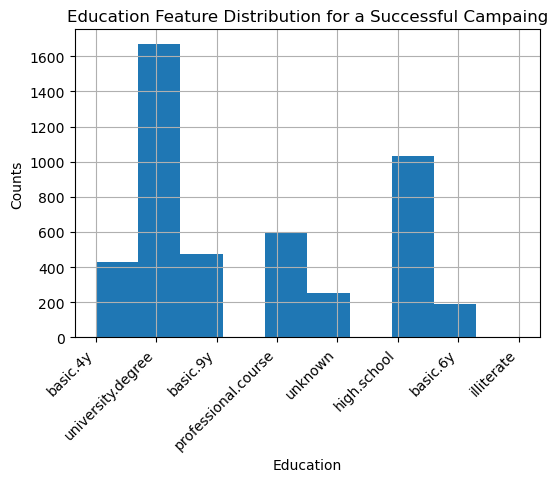

<Figure size 640x480 with 0 Axes>

In [26]:
# Education distribution for successful campaings
plt.figure(figsize=(6, 4))
df[df['y'] == 'yes']['education'].hist()
plt.title('Education Feature Distribution for a Successful Campaing')
plt.ylabel('Counts')
plt.xlabel('Education')
plt.xticks(rotation=45, ha='right')
plt.show()
plt.savefig('17-2-Education')

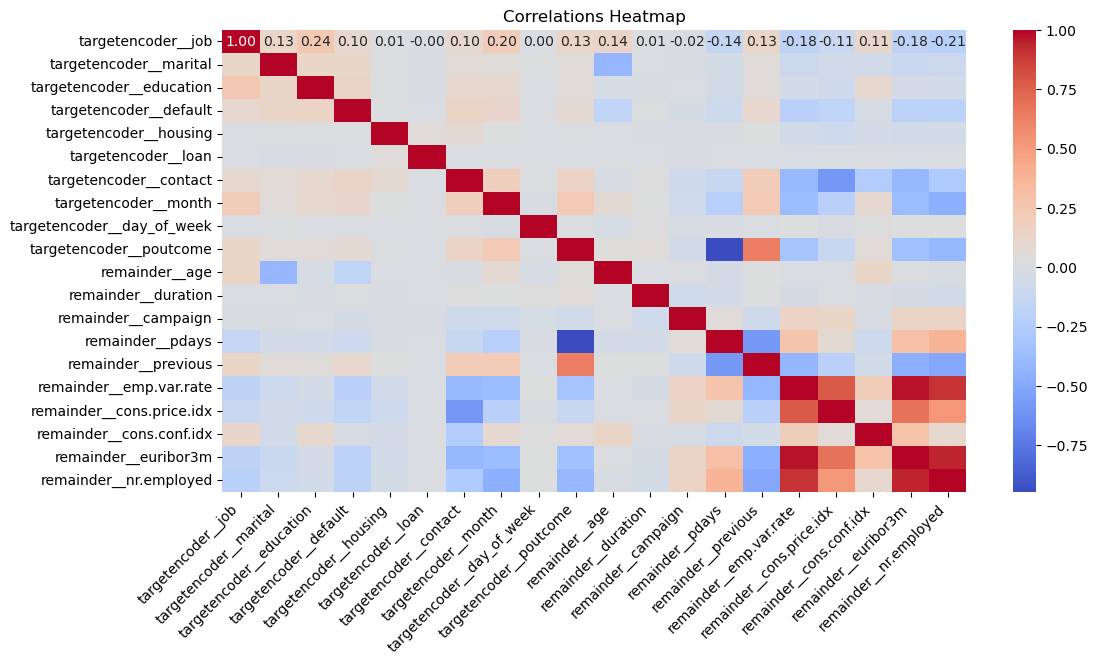

<Figure size 640x480 with 0 Axes>

In [27]:
# Heatmap to show relationships among features
plt.figure(figsize=(12, 6)) #Set the figure size (optional)
sns.heatmap(X_n.corr(), annot=True, cmap='coolwarm', fmt='.2f') 
plt.title('Correlations Heatmap') # Add a title (optional) 
plt.xticks(rotation=45, ha='right') 
plt.show() 
plt.savefig('17-3-Heatmap')

In [28]:
# Calling SelectFromModel
extractor = SelectFromModel(LogisticRegression(penalty='l1', solver = 'liblinear' ,random_state = 52))
extractor

SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=52,
                                             solver='liblinear'))

In [29]:
lgr_pipe = Pipeline([('selector', extractor),
                     ('lgr', LogisticRegression(random_state=52, max_iter = 1000))])

lgr_pipe.fit(X_train, y_train)
acc = lgr_pipe.score(X_test, y_test)

In [30]:
# Getting the coefficients and features
coef_df = ''

feature_names = transformer.get_feature_names_out()
selected_features =feature_names[ [int(i[1:]) for i in lgr_pipe.named_steps['selector'].get_feature_names_out()]]
clean_names = [i.split('__')[-1] for i in selected_features]
coef_df = pd.DataFrame({'feature': clean_names, 'coefs': lgr_pipe.named_steps['lgr'].coef_[0]})
coef_df['coefs'] = coef_df['coefs'].apply(abs)
coef_df = coef_df.sort_values(by = 'coefs', ascending = False)
coef_df.head(6)

,feature,coefs
4,contact,5.658351
2,education,2.955910
3,default,2.525684
5,month,2.478693
0,job,2.158537
12,emp.var.rate,1.255901


***As mentioned above under the definition of problem 11, these are the features with most important coefs for processing***

### Hyperparameter tuning and grid search

1. KNeighborsClassifier   - tuning params: n_neighbors, weights, metric, and p
2. DecisionTreeClassifier - tuning params: max_depth, min_samples_split, criterion, and min_samples_leaf
3. SVM                    - tuning params: C, kernel, gamma, degree
4. LogisticRegression     - tuning params: C, penalty,  and solver

In [17]:
# Calling TargetEncoder for the day_of_week and month, the rest are scaled 
transformer = make_column_transformer((TargetEncoder(), ['contact','month', 'education', 'job', 'default']),
                                      remainder = StandardScaler())

In [18]:
# Reducing the number of features
# Calling fit transformation on the reduced dataset
X_numerical = transformer.fit_transform(df[['emp.var.rate', 'contact', 'education', 'job', 'month', 'default']], y_numerical)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y_numerical, test_size = 0.4, random_state = 62)

In [110]:
# Dataframe to track best params
best_param_df = pd.DataFrame(columns = ['Model', 'Best Parameters'])

In [111]:
# Dataframe to track metrics
hyper_param_perf_df = pd.DataFrame(columns=['Model', 'Train Time',
                                            'Train Accuracy', 'Test Accuracy',
                                            'Train Precision', 'Test Precision',
                                            'Train Recall', 'Test Recall'])

***KNearestNeighborsClassifier***

In [112]:
# KNearestNeighborsClassifier

knn = KNeighborsClassifier()

params = {
    'n_neighbors': [9, 10, 11, 12],           # Number of neighbors to consider
    'weights': ['uniform', 'distance'],    # Weight function (uniform or distance-based)
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric
    'p': [1, 2]                            # Power parameter for Minkowski (p=1 is manhattan, p=2 is euclidean)
}

grid_knn = GridSearchCV(estimator = knn, param_grid=params, scoring='accuracy', cv=5)
grid_knn.fit(X_train, y_train)

# Getting predictions
preds_train = grid_knn.predict(X_train)
preds_test = grid_knn.predict(X_test)

# Calculating accuracy
accuracy_test = accuracy_score(y_test, preds_test)
accuracy_train = accuracy_score(y_train, preds_train)

# Calculating precision
precision_test = precision_score(y_test, preds_test)
precision_train = precision_score(y_train, preds_train)

# Calculating recall
recall_test = recall_score(y_test, preds_test)
recall_train = recall_score(y_test, preds_test)

# Best model 
grid_best_params = grid_knn.best_params_
grid_best_score = grid_knn.best_score_
grid_best_estimator = grid_knn.best_estimator_

#Getting Results
grid_score = grid_knn.score(X_test, y_test)

# Getting fit time 
best_index = grid_knn.best_index_
knn_results_mean_fit_time = grid_knn.cv_results_['mean_fit_time'][best_index]
#class_report = classification_report(y_test, preds_test)

# Keeping track of the metrics and best parameters
param_list = [item for pair in grid_best_params.items() for item in pair]
# Adding a new row using loc
best_param_df.loc[len(best_param_df)] = ['KNeighborsClassifier', param_list]
hyper_param_perf_df.loc[len(hyper_param_perf_df)] = ['KNeighborsClassifier', knn_results_mean_fit_time, accuracy_train, accuracy_test,
                                  precision_train, precision_test, recall_train, recall_test]
hyper_param_perf_df

,Model,Train Time,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall
0,KNeighborsClassifier,0.001329,0.921473,0.903527,0.689429,0.603734,0.462149,0.462149


***DecisionTreeClassifier***

In [24]:
#Decision Trees

tree = DecisionTreeClassifier()

params = {
    'max_depth': [3, 5, 10, 11, None], 
    'min_samples_split': [2, 3, 5, 10, 12],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 2, 4, 5]
}
# Fitting the model
grid_tree = GridSearchCV(estimator = tree, param_grid=params, scoring='accuracy', cv=5)
grid_tree.fit(X_train, y_train)

# Getting predictions
preds_train = grid_tree.predict(X_train)
preds_test = grid_tree.predict(X_test)

# Calculating accuracy
accuracy_test = accuracy_score(y_test, preds_test)
accuracy_train = accuracy_score(y_train, preds_train)

# Calculating precision
precision_test = precision_score(y_test, preds_test)
precision_train = precision_score(y_train, preds_train)

# Calculating recall
recall_test = recall_score(y_test, preds_test)
recall_train = recall_score(y_test, preds_test)

# Best model 
grid_best_params = grid_tree.best_params_
grid_best_score = grid_tree.best_score_
grid_best_estimator = grid_tree.best_estimator_

#Getting Results
grid_score = grid_tree.score(X_test, y_test)
# Getting fit time 
best_index = grid_tree.best_index_
tree_results_mean_fit_time = grid_tree.cv_results_['mean_fit_time'][best_index]
#classification_report = classification_report(y_test, preds_test)

# Keeping track of the metrics and best parameters
param_list = [item for pair in grid_best_params.items() for item in pair]
# Adding a new row using loc
best_param_df.loc[len(best_param_df)] = ['DecisionTreeClassifier', param_list]
hyper_param_perf_df.loc[len(hyper_param_perf_df)] = ['DecisionTreeClassifier', tree_results_mean_fit_time, accuracy_train, accuracy_test,
                                  precision_train, precision_test, recall_train, recall_test]
hyper_param_perf_df

,Model,Train Time,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall
0,KNeighborsClassifier,0.001348,0.921473,0.903527,0.689429,0.603734,0.462149,0.462149
1,DecisionTreeClassifier,0.027128,0.919207,0.912391,0.692740,0.671538,0.462149,0.462149


***SVC***

In [25]:
# SVM 

svc = SVC(probability=True)   # We need probability=True to get probabilities for ROC curve

params = {
    'C': [1, 10, 11],         # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'], # Kernel type
    'gamma': ['scale', 'auto'],      # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'degree': [2, 3],             # Degree for the 'poly' kernel (only used with 'poly')
}
# Fitting the model
grid_svc = GridSearchCV(estimator = svc, param_grid=params, scoring='accuracy', cv=5)
grid_svc.fit(X_train, y_train)

# Getting predictions
preds_train = grid_svc.predict(X_train)
preds_test = grid_svc.predict(X_test)

# Calculating accuracy
accuracy_test = accuracy_score(y_test, preds_test)
accuracy_train = accuracy_score(y_train, preds_train)

# Calculating precision
precision_test = precision_score(y_test, preds_test)
precision_train = precision_score(y_train, preds_train)

# Calculating recall
recall_test = recall_score(y_test, preds_test)
recall_train = recall_score(y_test, preds_test)

#Best model
grid_best_params = grid_svc.best_params_
grid_best_score = grid_svc.best_score_
grid_best_estimator = grid_svc.best_estimator_

#Getting Results
grid_score = grid_svc.score(X_test, y_test)
best_index = grid_svc.best_index_
svc_results_mean_fit_time = grid_svc.cv_results_['mean_fit_time'][best_index]
#classification_report = classification_report(y_test, preds_test)

# Keeping track of the metrics and best parameters
param_list = [item for pair in grid_best_params.items() for item in pair]
best_param_df.loc[len(best_param_df)] = ['SVC', param_list]
hyper_param_perf_df.loc[len(hyper_param_perf_df)] = ['SVC', svc_results_mean_fit_time, accuracy_train, accuracy_test,
                                  precision_train, precision_test, recall_train, recall_test]
hyper_param_perf_df

,Model,Train Time,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall
0,KNeighborsClassifier,0.001348,0.921473,0.903527,0.689429,0.603734,0.462149,0.462149
1,DecisionTreeClassifier,0.027128,0.919207,0.912391,0.692740,0.671538,0.462149,0.462149
2,SVC,12.422787,0.919247,0.909659,0.727821,0.678222,0.403917,0.403917


***LogisticRegression***

In [79]:
# Logistic Regression

logreg = LogisticRegression(max_iter = 1000, class_weight = 'balanced')

params = {
    'C': [0.1, 0.2, 0.205, 0.3],  # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet'],  # Norm used in penalization
    'solver': ['lbfgs', 'saga']  # Solvers (saga supports l1, l2, and elasticnet)
#   , 'l1_ratio': [0, 0.5, 1]        # L1 ratio (only used with 'elasticnet' penalty)
}
# Fitting the model
grid_logreg = GridSearchCV(estimator = logreg, param_grid=params, scoring='accuracy', cv=5)
grid_logreg.fit(X_train, y_train)

# Getting predictions
preds_train = grid_logreg.predict(X_train)
preds_test = grid_logreg.predict(X_test)

# Calculating accuracy
accuracy_test = accuracy_score(y_test, preds_test)
accuracy_train = accuracy_score(y_train, preds_train)

# Calculating precision
precision_test = precision_score(y_test, preds_test)
precision_train = precision_score(y_train, preds_train)

# Calculating recall
recall_test = recall_score(y_test, preds_test)
recall_train = recall_score(y_test, preds_test)

grid_best_params = grid_logreg.best_params_
grid_best_score = grid_logreg.best_score_
grid_best_estimator = grid_logreg.best_estimator_

#Getting Results
grid_score = grid_logreg.score(X_test, y_test)
# Getting fit time 
best_index = grid_logreg.best_index_
logreg_results_mean_fit_time = grid_logreg.cv_results_['mean_fit_time'][best_index]
#classification_report = classification_report(y_test, preds_test)

# Keeping track of the metrics and best parameters
param_list = [item for pair in grid_best_params.items() for item in pair]
# Adding a new row using loc
best_param_df.loc[len(best_param_df)] = ['LogisticRegression', param_list]
hyper_param_perf_df.loc[len(hyper_param_perf_df)] = ['LogisticRegression', logreg_results_mean_fit_time, accuracy_train, accuracy_test,
                                  precision_train, precision_test, recall_train, recall_test]
hyper_param_perf_df

,Model,Train Time,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall
0,KNeighborsClassifier,0.001348,0.921473,0.903527,0.689429,0.603734,0.462149,0.462149
1,DecisionTreeClassifier,0.027128,0.919207,0.912391,0.692740,0.671538,0.462149,0.462149
2,SVC,12.422787,0.919247,0.909659,0.727821,0.678222,0.403917,0.403917
3,LogisticRegression,1.443806,0.866910,0.861393,0.450148,0.445909,0.859714,0.859714


***Best parameters for each model***

In [93]:
# Setting the variable for panda display to 100
pd.set_option('display.max_colwidth', 100)
best_param_df

,Model,Best Parameters
0,KNeighborsClassifier,"[metric, euclidean, n_neighbors, 11, p, 1, weights, uniform]"
1,DecisionTreeClassifier,"[criterion, gini, max_depth, 5, min_samples_leaf, 2, min_samples_split, 5]"
2,SVC,"[C, 10, degree, 2, gamma, auto, kernel, rbf]"
3,LogisticRegression,"[C, 0.205, penalty, l1, solver, saga]"


In [94]:
# Setting the panda variable back to default
pd.reset_option('display.max_colwidth')

### Adjust your performance metric

So far fit time, accuracy, precision, and recall  are the metrics to compare the 4 models. Now Lift and ROC will be used adjusting the metrics.

Cumulative Gain Curves, or **Lift Charts**, are considered a better metric for marketing campaigns in classification models for several reasons, especially in scenarios where the objective is to target the most responsive or valuable segments of a population.

**Marketing campaigns, usually unbalanced**,  typically aim to optimize limited resources by identifying and targeting the most promising prospects (e.g., potential customers).

The **Cumulative Gain Curve** shows how well the model can rank instances (customers) in order of their likelihood to respond positively (e.g., make a purchase).

It helps marketers identify the smallest segment of the population that delivers the highest returns, and at the end the Cumulative Gain Curve directly addresses the business goal—targeting the right group of customers.

On the other hand **The ROC Curve** (Receiver Operating Characteristic curve) is a useful metric for marketing campaigns in classification models because it helps evaluate the model's ability to distinguish between classes (e.g., potential buyers vs. non-buyers) across different decision thresholds. Here’s why the ROC is valuable in this context.

In a marketing campaign, True Positives (TP) represent individuals correctly identified as likely to respond to the campaign (e.g., those who will make a purchase), while False Positives (FP) represent individuals incorrectly identified as likely to respond (those who won’t).

The ROC curve plots the True Positive Rate (TPR) (also called sensitivity or recall) against the False Positive Rate (FPR) at various classification thresholds. This helps marketers understand how well the model is at distinguishing between responders and non-responders across different cut-off points.

In this case Lift Charts are showing for example at the point 0.1(10%), 0.5(50%), meaning that if you score a dataset with the network and sort all of the cases by predicted probability of Yes, you would expect the top 10% to contain approximately 50% of all of the cases that actually take the category Yes, in the same way the top 30% of cases would contain >90% for most of the models, and so on. If you select 100% of the scored dataset, you obtain all of the successful clients in the dataset. Thus, using the model Logistic Regression can reduce the number of calls by 40% and get better results.

Next, **The Lift Curve** is derived from the cumulative gains chart; the values on the y axis correspond to the ratio of the cumulative gain for each curve to the baseline. Thus, the lift at 10% for the category Yes is 50%/10% = ~5.0 for most models. It provides another way of looking at the information in the cumulative gains chart.

Plotting **The Calibration Curves** of a classifier is useful for determining whether or not you can interpret their predicted probabilities directly as a confidence level. For instance, a well-calibrated binary classifier should classify the samples such that for samples to which it gave a score of 0.8, around 80% should actually be from the positive class.

Finally **The Confusion Matrix** for each model shows the values for TP, FP and FN, in this case the idea is to increase the number of people in the campaign that will say Yes and reduce the number of calls.


In [82]:
# Compute cumulative gains manually
def cumulative_gain_curve(y_true, y_prob):
    # Sort true labels by the probability of the positive class
    y_true = np.array(y_true)
    indices = np.argsort(-y_prob[:, 1])
    y_true_sorted = y_true[indices]

    # Calculate the cumulative sum of positives and total instances
    total_positives = np.sum(y_true == 1)
    cum_positives = np.cumsum(y_true_sorted)
    gain = cum_positives / total_positives

    # Append 0 at the start for plotting from the origin
    gain = np.insert(gain, 0, 0)

    # Percentage of instances considered
    percentages = np.arange(len(gain)) / len(y_true)

    return percentages, gain

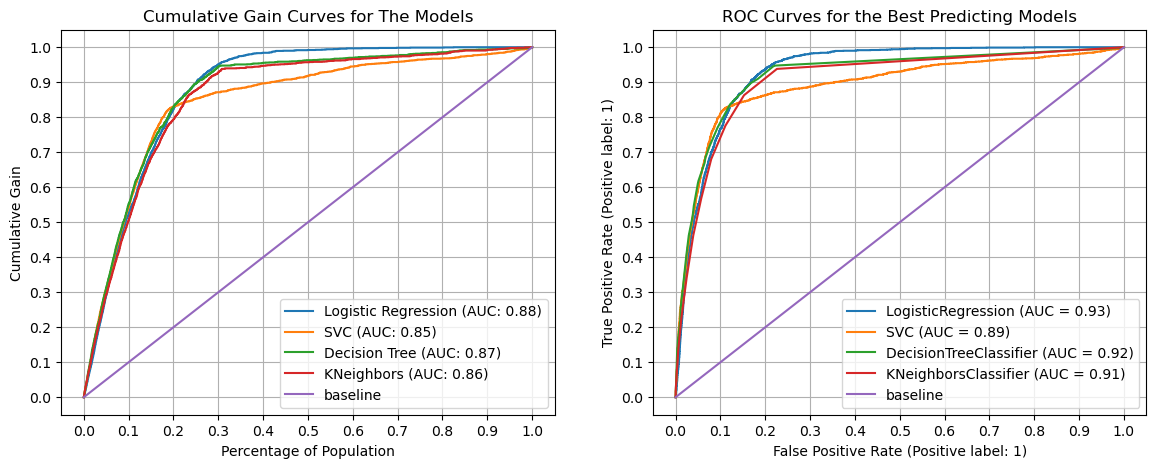

<Figure size 640x480 with 0 Axes>

In [98]:
from sklearn.metrics import auc as skl_auc
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc
import scikitplot as skplt
import matplotlib.ticker as mticker

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14, 5)
plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.yticks(np.arange(0.0, 1.1, 0.1))

#Getting the probabilities for the models
logreg_probs = grid_logreg.predict_proba(X_test)
#f1 = skplt.metrics.plot_cumulative_gain(y_test, logreg_probs, ax=ax[0])
knn_probs = grid_knn.predict_proba(X_test)
tree_probs = grid_tree.predict_proba(X_test)
svc_probs = grid_svc.predict_proba(X_test)
# Setting the models in a dic
models = {
    "Logistic Regression": LogisticRegression(),
    "SVC": SVC(probability=True),  # Enable probability estimates for SVC
    "Decision Tree": DecisionTreeClassifier(),
    "KNeighbors": KNeighborsClassifier()
}
# Assigning the probs to the models
y_probs = {}
y_probs["Logistic Regression"] = logreg_probs
y_probs["SVC"] = svc_probs
y_probs["Decision Tree"] = tree_probs
y_probs["KNeighbors"] = knn_probs

# Looping to plot the cumulative gain with the AUC - Area under the curve    
for name, y_prob in y_probs.items():
    percentages, gains = cumulative_gain_curve(y_test, y_prob)
    ax[0].plot(percentages, gains, label=f'{name} (AUC: {np.trapz(gains, percentages):.2f})')

ax[0].plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
ax[0].set_xticks(np.arange(0.0, 1.1, 0.1))
ax[0].set_yticks(np.arange(0.0, 1.1, 0.1))
ax[0].set_xlabel('Percentage of Population')
ax[0].set_ylabel('Cumulative Gain')
ax[0].set_title('Cumulative Gain Curves for The Models')
ax[0].legend(loc='lower right')
ax[0].grid(True)

#fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(grid_logreg.best_estimator_, X_test, y_test, ax = ax[1])
RocCurveDisplay.from_estimator(grid_svc.best_estimator_, X_test, y_test, ax = ax[1])
RocCurveDisplay.from_estimator(grid_tree.best_estimator_, X_test, y_test, ax = ax[1])
RocCurveDisplay.from_estimator(grid_knn.best_estimator_, X_test, y_test, ax = ax[1])

plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.title('ROC Curves for the Best Predicting Models')
plt.legend();
plt.grid()
plt.show()
plt.savefig('17-5-Curves')

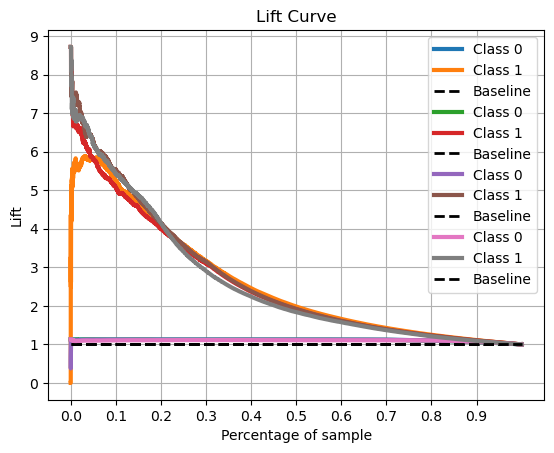

In [84]:
# Lift Curve
logreg_probs = grid_logreg.predict_proba(X_test)
f1 = skplt.metrics.plot_lift_curve(y_test, logreg_probs, ax=plt.gca())

knn_probs = grid_knn.predict_proba(X_test)
f2 = skplt.metrics.plot_lift_curve(y_test, knn_probs, ax=plt.gca())

tree_probs = grid_tree.predict_proba(X_test)
f3 = skplt.metrics.plot_lift_curve(y_test, tree_probs, ax=plt.gca())

svc_probs = grid_svc.predict_proba(X_test)
f4 = skplt.metrics.plot_lift_curve(y_test, svc_probs, ax=plt.gca())

plt.xticks(np.arange(0.0, 1.0, 0.1))
plt.yticks(np.arange(0.0, 10.0, 1))
f1.plot()
f2.plot()
f3.plot()
f4.plot()
plt.legend();
plt.show()

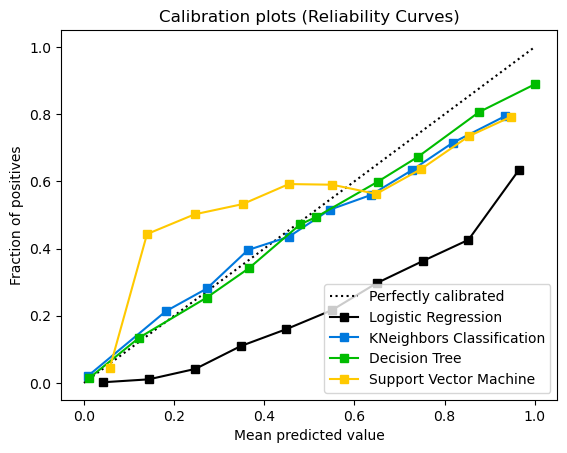

In [86]:
#The Calibration Curves
probas_list = [logreg_probs, knn_probs, tree_probs, svc_probs]
clf_names = ['Logistic Regression', 'KNeighbors Classification',
             'Decision Tree', 'Support Vector Machine']
skplt.metrics.plot_calibration_curve(y_test, 
                                     probas_list, 
                                     clf_names)
plt.show()

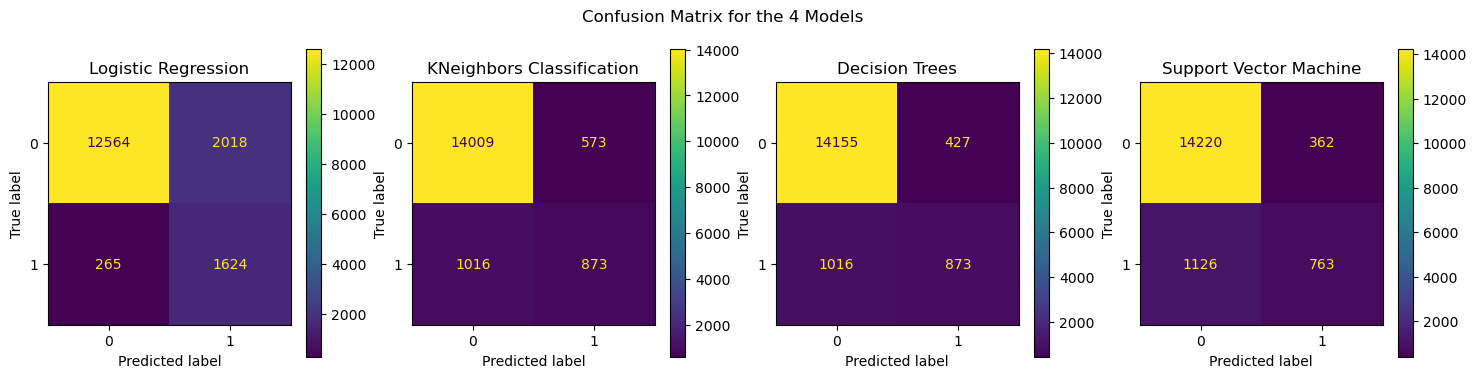

In [104]:
# Plotting the Confusion Metrics for all 4 Model as a base to compare
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(18, 4)

# Confusion Matrix
preds_test = grid_logreg.predict(X_test)
conf_matrix = confusion_matrix(y_test, preds_test)
disp1 = ConfusionMatrixDisplay(conf_matrix)
ax[0].set_title('Logistic Regression')
disp1.plot(ax=ax[0])

preds_test = grid_knn.predict(X_test)
conf_matrix = confusion_matrix(y_test, preds_test)
disp1 = ConfusionMatrixDisplay(conf_matrix)
ax[1].set_title('KNeighbors Classification')
disp1.plot(ax=ax[1])

preds_test = grid_tree.predict(X_test)
conf_matrix = confusion_matrix(y_test, preds_test)
disp1 = ConfusionMatrixDisplay(conf_matrix)
ax[2].set_title('Decision Trees')
disp1.plot(ax=ax[2])

preds_test = grid_svc.predict(X_test)
conf_matrix = confusion_matrix(y_test, preds_test)
disp1 = ConfusionMatrixDisplay(conf_matrix)
ax[3].set_title('Support Vector Machine')
disp1.plot(ax=ax[3])

fig.suptitle('Confusion Matrix for the 4 Models')
plt.show()

### Conclusions & Deployment:
### Data:
The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts. During these phone campaigns, an attractive long-term deposit application, with good interest rates, was offered. For each contact, a large number of attributes was stored and if there was a success (the target variable).
The target variable shows an unbalanced class, which is usually the case for campaigns.
There are not null values on the dataset.

### Business Objective:
The business objective is to increase the efficiency of phone campaigns for long-term deposit subscriptions by reducing the number of contacts, while identifying the key characteristics that influence success. This will enable better management of available resources—such as human effort, phone calls, and time—by focusing on a high-quality, cost-effective campaigns set of potential customers.

### Engineering Features:
Started with JamesSteinEncoder because of how it manages features with many unique values (i.e month), however, it gives lower performance for classification problems. 
Switch to TargetEncoder has similar features but it is better for binary classification. Noticed that the performance and metrics are better with TargetEncoder.
The transformer below encodes and scaled the data.

### Train/Test Split
Used test size of 40% given the large number of records (41188), the size of the test data also affects the results. Thus the larger the test data the lower the scores for the same models.

### First Iteration: A Baseline Model
Used a DummyClassifier for the baseline with accuracy of **0.8853**

### Second Iteration: A Simple Model
Use Logistic Regression to build a basic model on your data with accuracy of **0.91**

### Third Iteration: Model Comparisons
Build and fit 4 models: Logistic Regression, KNN, Decision Tree, and SVM using the default parameters.
**Results:*
*Best Score: LogisticRegression
*Best Fit Time: KNeighborsClassifier

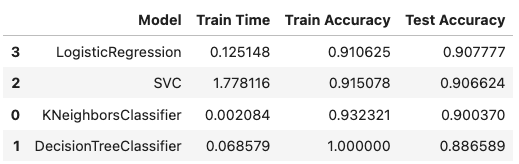

### Fourth Iteration: Improving the Model - Tuning Parameters
1. The remaining features, after gender, will stay in the dataset for two major reasons: First, as shown in the heapmap graph below, there is interdependence among the features, they are correlated. Second, the features do not have a normal distribution on the values, please see the graph for "education" below when the campaigns were successful.
2. However, given the size of the dataset I am using SelectFromModel with LogistRegression to get the most important features for the classification work with a reduced number of features. This is done to reduce the computational cost, specially for SVC the process does not end with all records in the dataframe.
3. As a result the scores will be a bit lower, however, still valid and can formulate conclusions.
**Results:**
*Best Score: Decision Tress
*Best Fit Time: KNeighborsClassifier

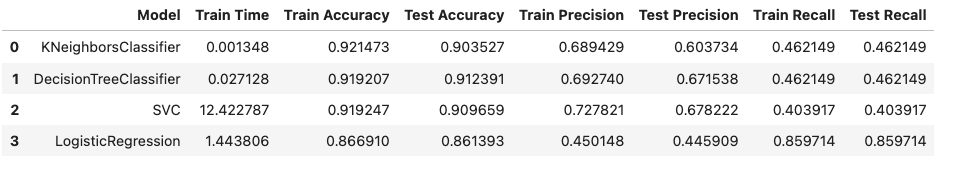

**Best Parameters:**
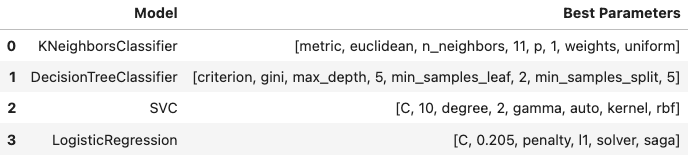

### Adjust your performance metric
So far fit time, accuracy, precision, and recall  are the metrics to compare the 4 models. Now Lift and ROC will be used adjusting the metrics.
Cumulative Gain Curves, or **Lift Charts**, are considered a better metric for marketing campaigns in classification models for several reasons, especially in scenarios where the objective is to target the most responsive or valuable segments of a population.

**Marketing campaigns, usually unbalanced**,  typically aim to optimize limited resources by identifying and targeting the most promising prospects (e.g., potential customers).

**The Cumulative Gain Curve** shows how well the model can rank instances (customers) in order of their likelihood to respond positively (e.g., make a purchase).

It helps marketers identify the smallest segment of the population that delivers the highest returns, and at the end the Cumulative Gain Curve directly addresses the business goal—targeting the right group of customers.

On the other hand **The ROC Curve** (Receiver Operating Characteristic curve) is a useful metric for marketing campaigns in classification models because it helps evaluate the model's ability to distinguish between classes (e.g., potential buyers vs. non-buyers) across different decision thresholds.

In this case Lift Charts are showing for example at the point 0.1 (10%), 0.5 (50%), meaning that if you score a dataset with the network and sort all of the cases by predicted probability of Yes, you would expect the top 10% to contain approximately 50% of all of the cases that actually take the category Yes, in the same way the top 30% of cases would contain >90% of sucessful calls, and so on. If you select 100% of the scored dataset, you obtain all of the successful clients in the dataset. Thus, using the model Logistic Regression can reduce the number of calls by 30% and get better results. These graphs look very similar because of the large number of records in the dataframe.

**The cumulative gain curves and ROC curves show the Logistic Regression as best model with AUC of 0.88 and 0.93.**

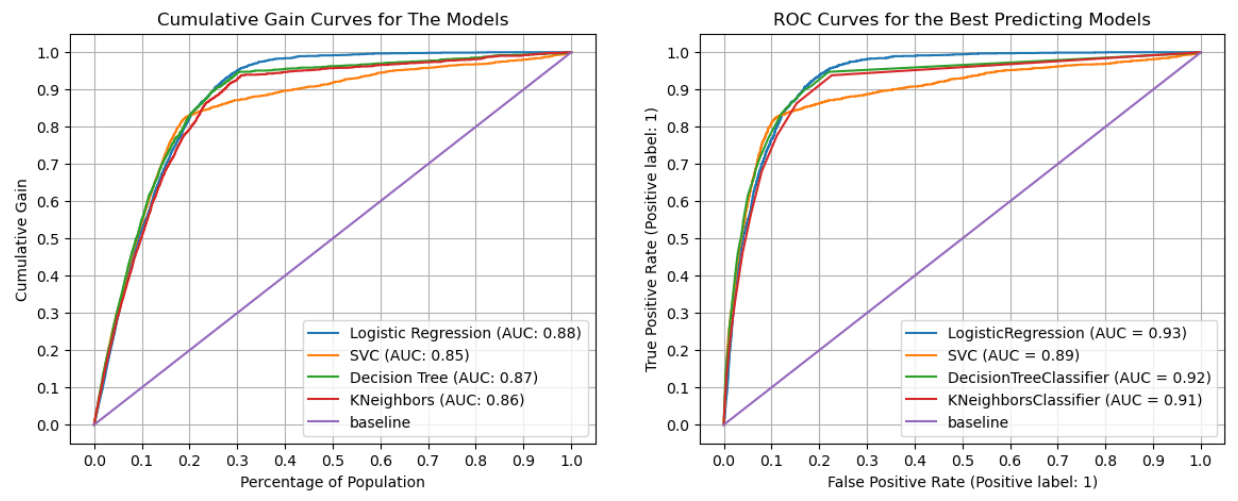

Next, **the lift curve* is derived from the cumulative gains chart; the values on the y axis correspond to the ratio of the cumulative gain for each curve to the baseline. Thus, the lift at 10% for the category Yes is 50%/10% = 5.0. It provides another way of looking at the information in the cumulative gains chart.

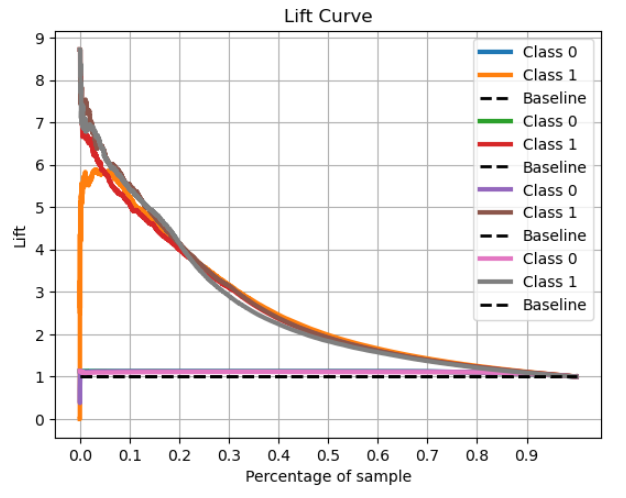

Plotting **the calibration curves** of a classifier is useful for determining whether or not you can interpret their predicted probabilities directly as a confidence level. For instance, a well-calibrated binary classifier should classify the samples such that for samples to which it gave a score of 0.8, around 80% should actually be from the positive class.

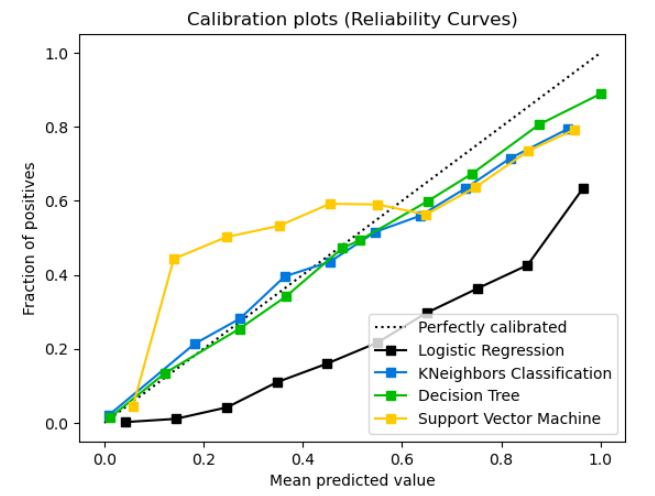

Finally **the confusion matrix** for each model shows the values for TP, FP and FN, in this case the idea is to increase the number of people in the campaign that will say Yes and reduce the number of calls.

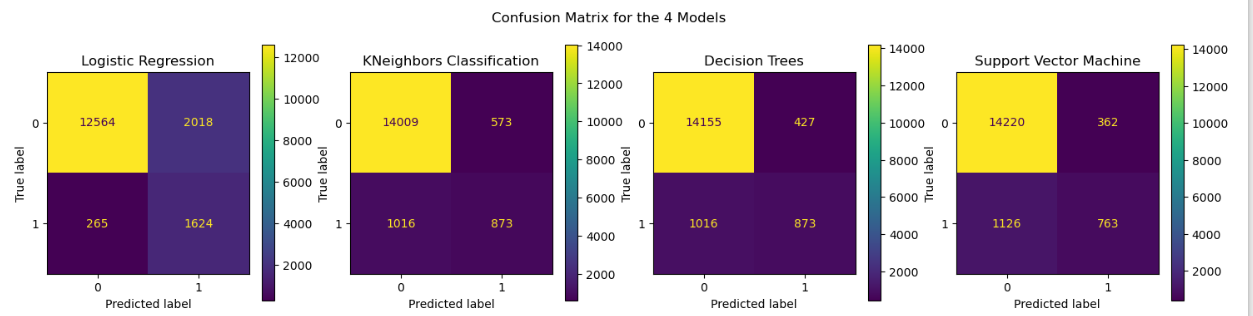

### Next Steps and Recommendations:
1. Campaings can make 30% less calls and still getting 90% sucess in the customers representing around 41% increase in customers signing for the long-term deposit application 
2. Redefine further the parameters, due to the large dataset it takes quite some time to run, specially SVC - maybe get a better processing in GO 
3. Run the tuned models with the complete list of features
4. Metrics can be tune/redefine to get better understanding of the models outputs
5. Replace the GridSearchCV with HalvingRandomSearchCV or RandomizeSearchCV and compare the results